In [1]:
!nvidia-smi

Wed May 14 10:51:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%%capture
!pip install lightning wandb

### Quick Note

If you'd love to log metrics with wandb:
- in the cell below, remove comment from this line `wandb.login(key = "")`and provide your key.
- remove comment from this lin `logger = pl.loggers.WandbLogger(project = "Tomato Disease Classifier Project")`, you could also change the project name to what you'd want it to be.
- To conclude and finish wandb run, similarly, remove comment from the line: `wandb.finish()`

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
plt.style.use("fivethirtyeight")
import PIL
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
from matplotlib import image
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import os, shutil, tqdm
from tqdm.auto import tqdm, trange

import torch, torchvision, torchmetrics, torchinfo
import torch.nn as nn
from torchinfo import summary
from torchvision.transforms import v2 as v2
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, RandomSampler
import lightning.pytorch as pl
from lightning.pytorch import Trainer, LightningModule, LightningDataModule

import wandb
# wandb.login(key = "")

In [4]:
train_dir = "/kaggle/input/tomato-disease-multiple-sources/train"
val_dir = "/kaggle/input/tomato-disease-multiple-sources/valid"

In [5]:
# Verify that both train and validation directories have the same classes

print(set(sorted(os.listdir(val_dir))).difference(sorted(os.listdir(train_dir))))
print(np.mean(sorted(os.listdir(val_dir)) == sorted(os.listdir(train_dir))))

set()
1.0


In [6]:
# Get image paths and corresponding classes

def get_paths_and_classes(path_:str) -> tuple:
    ims, labels = [], []
    for class_name in tqdm(os.listdir(path_), desc = f"Going through {path_.split('/')[-1]} directory"):
        for image_file in os.listdir(path_+"/"+class_name):
            im_path = path_ + "/" + class_name + "/" + image_file
            ims.append(im_path)
            labels.append(class_name)
    return ims, labels

train_ims, train_labels = get_paths_and_classes(train_dir)
val_ims, val_labels = get_paths_and_classes(val_dir)

print(len(train_ims), len(train_labels))
print(len(val_ims), len(val_labels))

Going through train directory:   0%|          | 0/11 [00:00<?, ?it/s]

Going through valid directory:   0%|          | 0/11 [00:00<?, ?it/s]

25851 25851
6684 6684


In [7]:
def get_df(ims:list, labels:list) -> pd.DataFrame:
    df = pd.DataFrame(data = {
        "image path": ims,
        "label": labels
    })
    return df

train_df = get_df(train_ims, train_labels)
val_df = get_df(val_ims, val_labels)
val_df = val_df[val_df["image path"]!='/kaggle/input/tomato-disease-multiple-sources/valid/healthy/HL_(336).png']
train_df["label"] = train_df["label"].replace("Spider_mites Two-spotted_spider_mite", "Spider_mites")
val_df["label"] = val_df["label"].replace("Spider_mites Two-spotted_spider_mite", "Spider_mites")
train_df = shuffle(train_df)
val_df = shuffle(val_df)

print(f'no of images in both train and validation split: {len(set(train_df["image path"]).intersection(val_df["image path"]))}')
print('train shape:', train_df.shape, "validation shape", val_df.shape)

no of images in both train and validation split: 0
train shape: (25851, 2) validation shape (6683, 2)


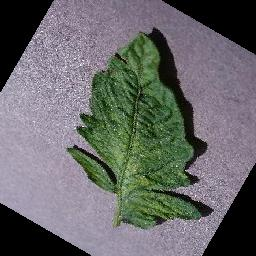

In [8]:
Image.open(train_df.iloc[0]["image path"])

In [9]:
display(train_df["label"].value_counts(normalize = True)*100, val_df["label"].value_counts(normalize = True)*100)

label
Late_blight                      12.042087
healthy                          11.802251
Septoria_leaf_spot               11.148505
Bacterial_spot                   10.931879
Leaf_Mold                        10.653360
Early_blight                      9.496731
Tomato_mosaic_virus               8.328498
Tomato_Yellow_Leaf_Curl_Virus     7.887509
Target_Spot                       7.067425
Spider_mites                      6.757959
powdery_mildew                    3.883796
Name: proportion, dtype: float64

label
healthy                          12.045489
Late_blight                      11.850965
Septoria_leaf_spot               11.162652
Leaf_Mold                        11.057908
Bacterial_spot                   10.953165
Early_blight                      9.621428
Tomato_mosaic_virus               8.738590
Tomato_Yellow_Leaf_Curl_Virus     7.451743
Target_Spot                       6.838246
Spider_mites                      6.509053
powdery_mildew                    3.770762
Name: proportion, dtype: float64

CPU times: user 250 ms, sys: 11 ms, total: 261 ms
Wall time: 356 ms


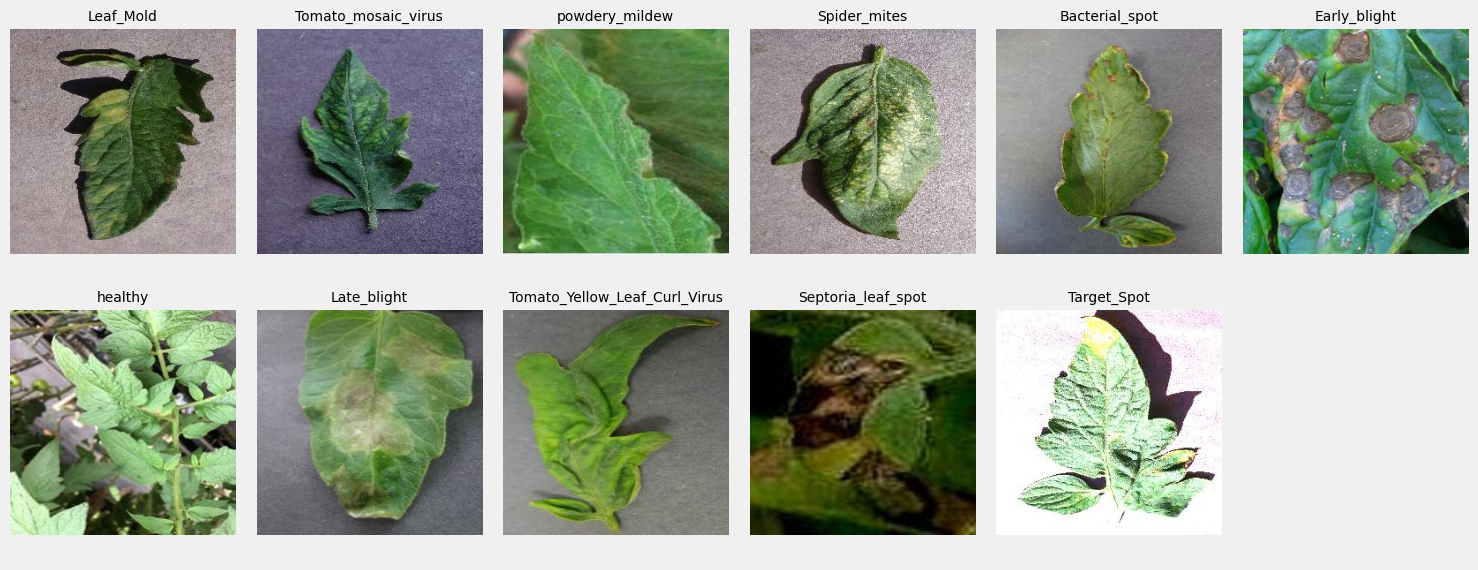

In [10]:
%%time
def plot_image_per_class():
    image_, label = list(), list()
    for class_ in val_df["label"].unique():
        sel_df = val_df[val_df["label"] == class_].iloc[0]
        image_.append(image.imread(sel_df["image path"]))
        label.append(sel_df["label"])
    
    fig, ax = plt.subplots(nrows = 2, ncols = 6, figsize = (15,6))
    ax = ax.flatten()
    for i in ax:
        i.axis("off")
    
    for im, lbl, axi in zip(image_, label, ax):
        axi.imshow(im)
        axi.set_title(lbl, color = "black", fontweight = None, fontsize = 10)
        axi.axis("off")
    plt.tight_layout()


plot_image_per_class()

In [11]:
# Map classes

class_map = dict()
inv_class_map = dict()
for num, class_ in dict(enumerate([i for i in val_df["label"].unique()])).items():
    class_map[class_] = num

for num, class_ in dict(enumerate([i for i in val_df["label"].unique()])).items():
    inv_class_map[num] = class_


train_df["label"] = train_df["label"].map(class_map)
val_df["label"] = val_df["label"].map(class_map)

display(inv_class_map, class_map)

{0: 'Leaf_Mold',
 1: 'Tomato_mosaic_virus',
 2: 'powdery_mildew',
 3: 'Spider_mites',
 4: 'Bacterial_spot',
 5: 'Early_blight',
 6: 'healthy',
 7: 'Late_blight',
 8: 'Tomato_Yellow_Leaf_Curl_Virus',
 9: 'Septoria_leaf_spot',
 10: 'Target_Spot'}

{'Leaf_Mold': 0,
 'Tomato_mosaic_virus': 1,
 'powdery_mildew': 2,
 'Spider_mites': 3,
 'Bacterial_spot': 4,
 'Early_blight': 5,
 'healthy': 6,
 'Late_blight': 7,
 'Tomato_Yellow_Leaf_Curl_Virus': 8,
 'Septoria_leaf_spot': 9,
 'Target_Spot': 10}

In [12]:
class tomatoDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transforms):
        super().__init__()
        self.df = df
        self.transforms = transforms

    def __getitem__(self, idx):
        image_ = Image.open(self.df.iloc[idx]["image path"]).convert("RGB")
        label = self.df.iloc[idx]["label"]
        if self.transforms is not None:
            return self.transforms(image_), label
        else:
            return image_, label

    def __len__(self):
        return len(self.df)

In [13]:
# Augmentations/Transforms

train_transform = v2.Compose(
    [
        v2.Resize(size = (224, 224)),
        v2.RandomAutocontrast(p = .5),
        v2.RandomAffine(degrees = 15, scale = [.76, .95]),
        v2.RandomAdjustSharpness(sharpness_factor = 2, p = .23),
        v2.RandomHorizontalFlip(p = .45),
        v2.RandomRotation(degrees = (10, 50)),
        v2.RandomVerticalFlip(p = .45),
        v2.ToImage(),
        v2.ToDtype(dtype = torch.float32, scale = True),
        v2.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)
val_transform = v2.Compose(
    [
        v2.Resize(size = (224, 224)),
        v2.ToImage(),
        v2.ToDtype(dtype = torch.float32, scale = True),
        v2.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

In [14]:
train_dataset = tomatoDataset(df = train_df, transforms = train_transform)
val_dataset = tomatoDataset(df = val_df, transforms = val_transform)

In [15]:
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 64,
    num_workers = os.cpu_count(),
    persistent_workers = True,
    pin_memory = True,
    shuffle = True
)
val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 64,
    num_workers = os.cpu_count(),
    persistent_workers = True,
    pin_memory = True,
    shuffle = False
)

len(train_dataloader), len(val_dataloader)

(404, 105)

In [16]:
def plot_dataloader(dataloader):
    images = list()
    labels = list()
    for num, (image, label) in enumerate(tqdm(dataloader)):
        if num == 1:
            for im in image:
                images.append(np.moveaxis(im.numpy(), (0,1,2), (2,0,1)))
            for lbl in label:
                labels.append(inv_class_map[lbl.item()])
        elif num > 1:
            break
    fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (18,11.5))
    ax = ax.flatten()
    for i in ax:
        i.axis("off")
    
    for im, lbl, axi in zip(images[:8], labels[:8], ax):
        axi.imshow(im)
        axi.set_title(lbl, color = "black", fontweight = "bold")
        axi.axis("off")
    plt.tight_layout()

  0%|          | 0/404 [00:00<?, ?it/s]

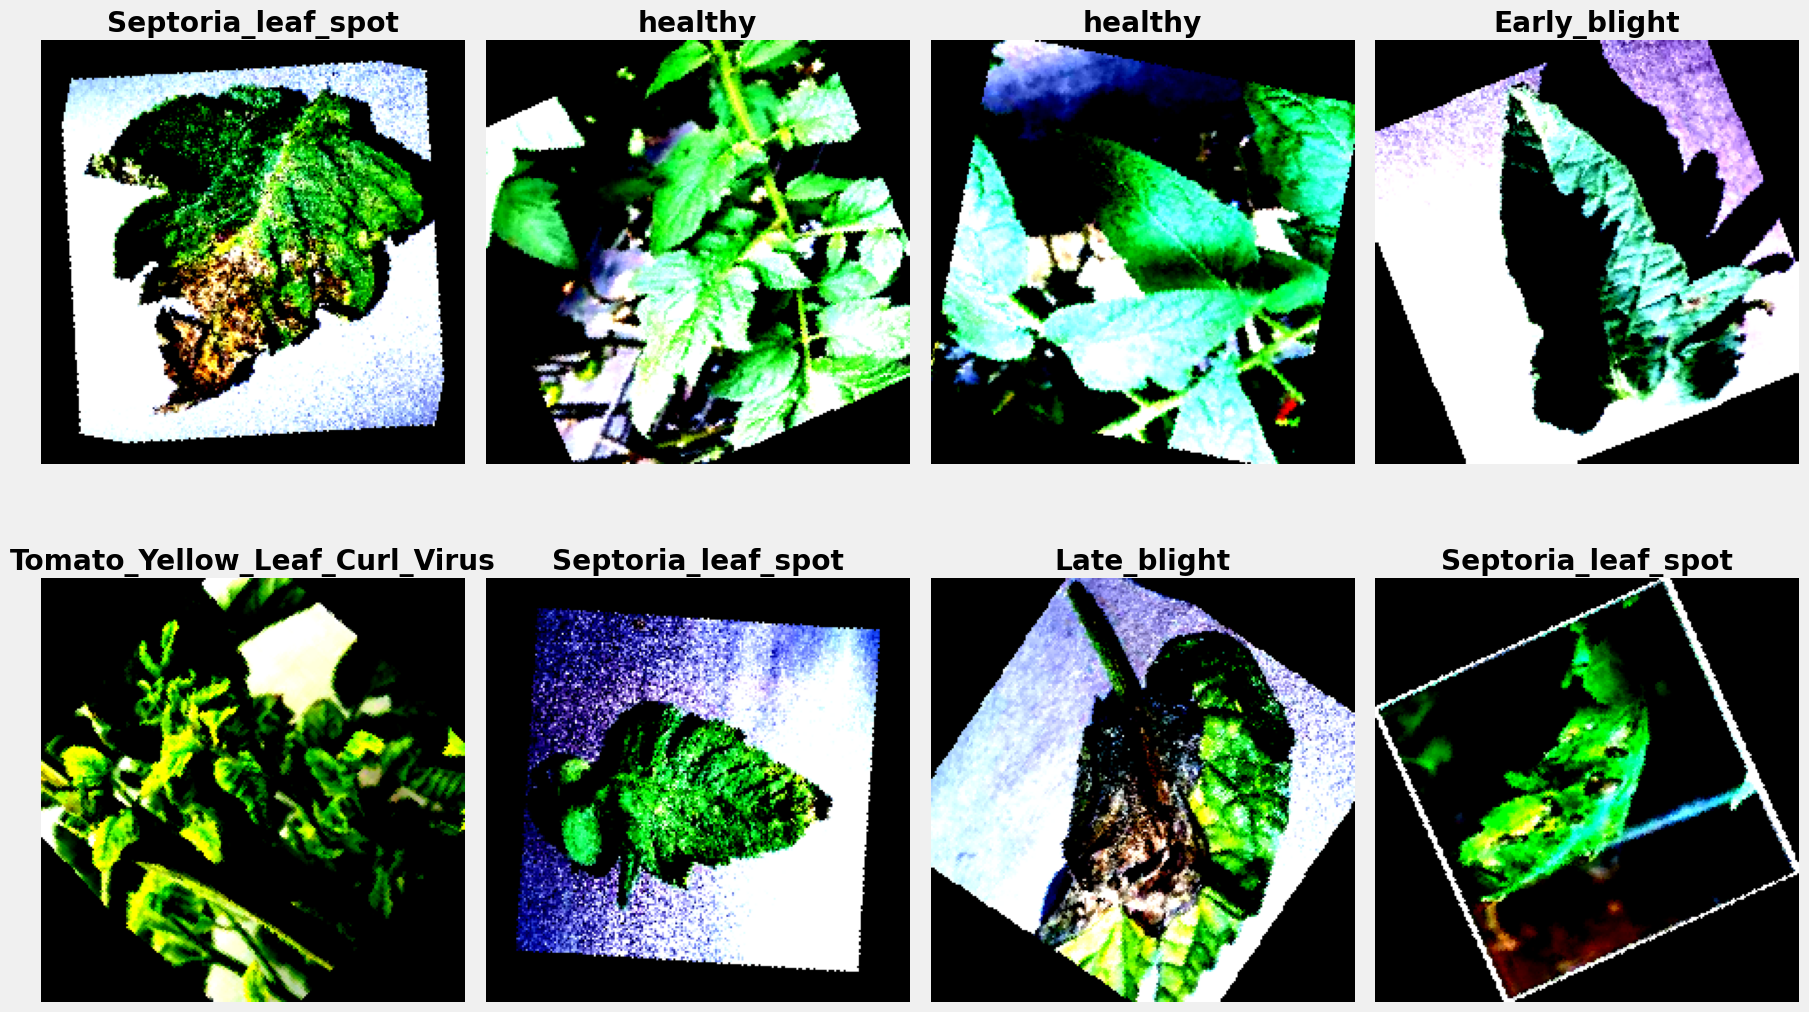

In [17]:
plot_dataloader(train_dataloader)

  0%|          | 0/105 [00:00<?, ?it/s]

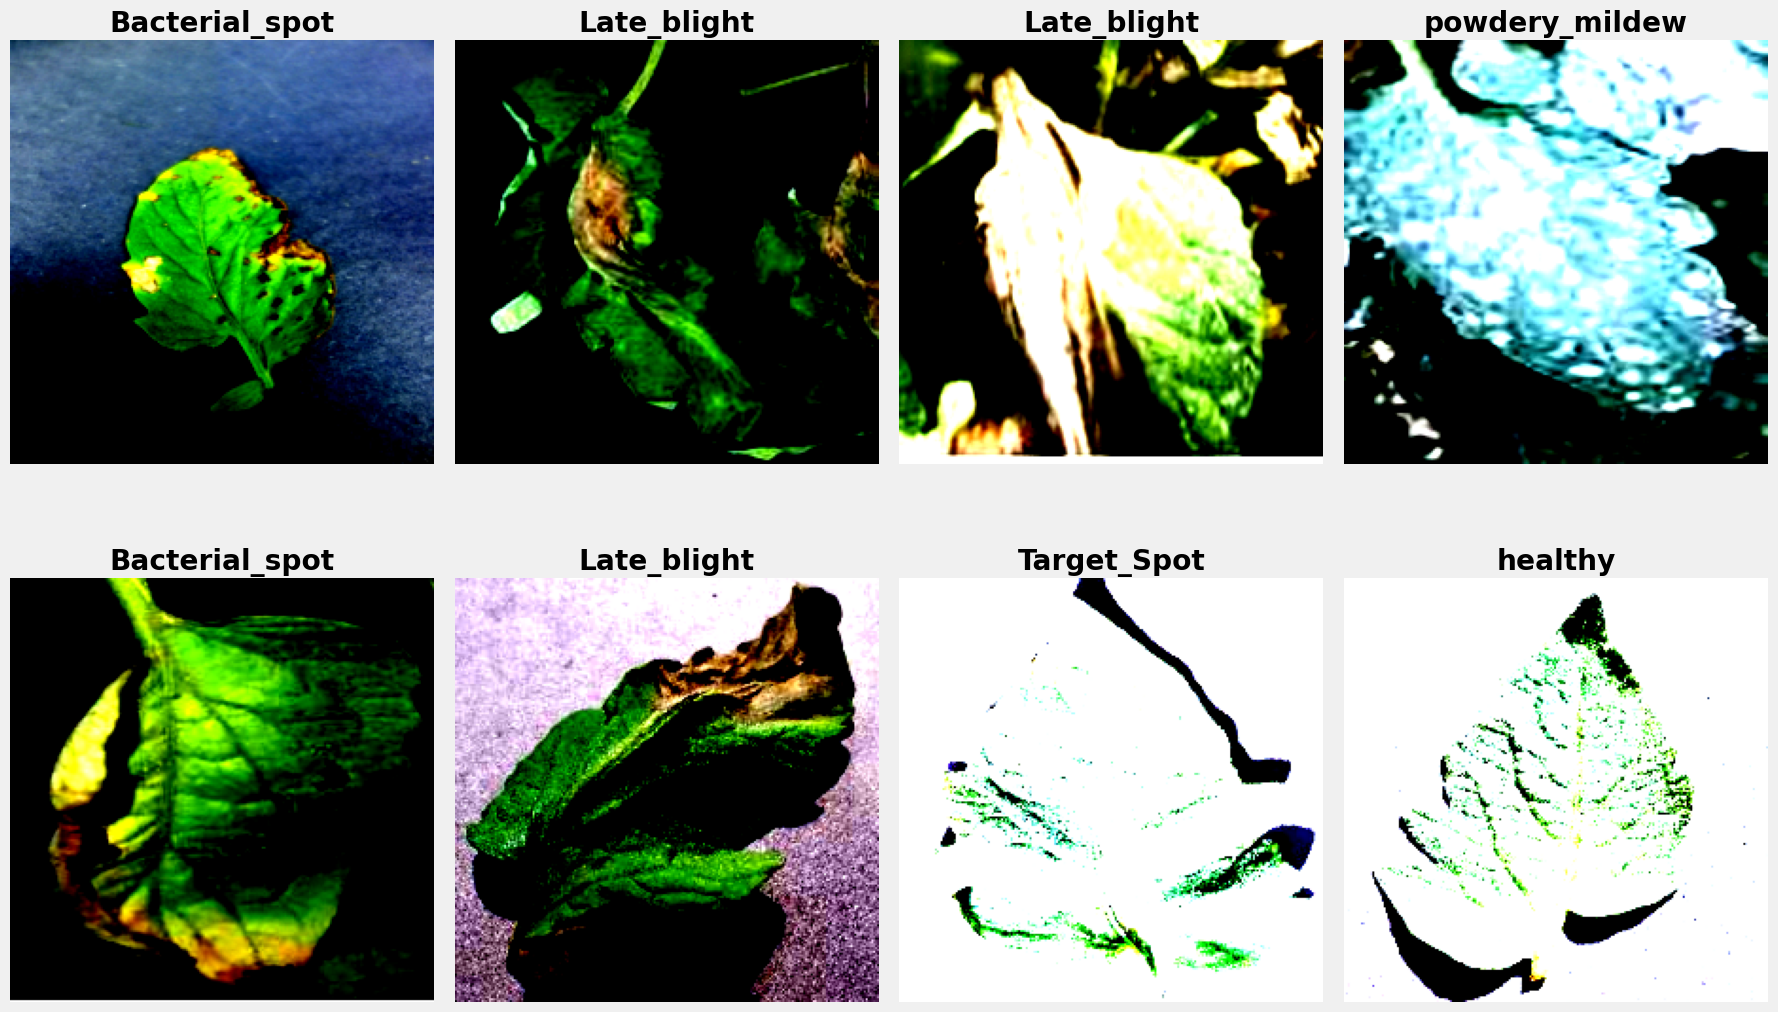

In [18]:
plot_dataloader(val_dataloader)

In [19]:
class myDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, t_tf, v_tf):
        super().__init__()
        self.batch_size = batch_size
        self.t_tf = t_tf
        self.v_tf = v_tf

    def setup(self, stage:str):
        self.train_dataset = tomatoDataset(df = train_df, transforms = self.t_tf)
        self.val_dataset = tomatoDataset(df = val_df, transforms = self.v_tf)

    def train_dataloader(self):
        train_dataloader = DataLoader(
            dataset = self.train_dataset,
            batch_size = self.batch_size,
            num_workers = os.cpu_count(),
            persistent_workers = True,
            pin_memory = True,
            shuffle = True
        )
        return train_dataloader

    def val_dataloader(self):
        val_dataloader = DataLoader(
            dataset = self.val_dataset,
            batch_size = self.batch_size,
            num_workers = os.cpu_count(),
            persistent_workers = True,
            pin_memory = True,
            shuffle = False
        )
        return val_dataloader

In [20]:
class myLightningModel(pl.LightningModule):
    def __init__(self, model, lr):
        super().__init__()
        self.model = model
        self.lr = lr
        self.loss_fn = nn.CrossEntropyLoss()
        self.metric_fn = torchmetrics.classification.MulticlassAccuracy(num_classes = 11)
        self.save_hyperparameters(ignore = ["model"])

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        self.model.train()
        X, y = batch
        logits = self.model(X)
        loss = self.loss_fn(logits, y)
        acc = self.metric_fn(torch.flatten(torch.argmax(torch.softmax(logits, dim = 1), axis = 1)), y)
        self.log("Train accuracy", acc, prog_bar = True, on_epoch = True, on_step = False)
        self.log("Train logloss", loss, prog_bar = True, on_epoch = True, on_step = False)
        return {"Train Accuracy": acc, "loss": loss}

    def validation_step(self, batch, batch_idx):
        self.model.eval()
        X, y = batch
        logits = self.model(X)
        val_loss = self.loss_fn(logits, y)
        val_acc = self.metric_fn(torch.flatten(torch.argmax(torch.softmax(logits, dim = 1), axis = 1)), y)
        self.log("Val accuracy", val_acc, prog_bar = True, on_epoch = True, on_step = False)
        self.log("Val logloss", val_loss, prog_bar = True, on_epoch = True, on_step = False)
        return {"Val Accuracy": val_acc, "Val loss": val_loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params = self.model.parameters(), lr = self.lr, weight_decay = 1e-4)
        return optimizer

In [21]:
pl.seed_everything(1906)
model = torchvision.models.efficientnet.efficientnet_b0(progress = True, weights = torchvision.models.efficientnet.EfficientNet_B0_Weights.DEFAULT)
model.classifier = nn.Sequential(
  nn.Dropout(p=0.2, inplace=True),
  nn.Linear(in_features=1280, out_features=len(class_map), bias=True)
)
my_lightning_model = myLightningModel(model = model, lr = 1e-3)
dm = myDataModule(batch_size = 32, t_tf = train_transform, v_tf = val_transform)
trainer = pl.Trainer(
    accelerator = "auto",
    devices = "auto",
    precision = "16-mixed",
    deterministic = True,
    max_epochs = 15,
    # logger = pl.loggers.WandbLogger(project = "Tomato Disease Classifier Project"),
    # pl.callbacks.RichProgressBar(leave = True)
    callbacks=[pl.callbacks.ModelCheckpoint(
                        dirpath = os.getcwd() + "/checkpoints",
                        mode = "min",
                        monitor = "Val logloss",
                        save_top_k = 2,
                        save_last = True
                    )]
)

INFO: Seed set to 1906
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 204MB/s]
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(model = my_lightning_model, datamodule = dm)
# trainer.validate(model = my_lightning_model, datamodule = dm)
# wandb.finish()

2025-05-14 10:53:10.394175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747219990.619059      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747219990.680314      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | EfficientNet       | 4.0 M  | train
1 | loss_fn   | CrossEntropyLoss   | 0      | train
2 | metric_fn | MulticlassAccuracy | 0      | train
---------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.


In [23]:
print("FIN")

FIN
